In [64]:
from scipy import io as spio
import numpy as np
# Датасет руписних літер
emnist = spio.loadmat("emnist-letters.mat")

# Завантаження тренувальної вибірки
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

# Завантаження тренувальної вибірки
y_train = emnist["dataset"][0][0][0][0][0][1]

# Завантаження тестової вибірки
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

# Завантаження тестової вибірки
y_test = emnist["dataset"][0][0][1][0][0][1]


In [65]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch    

In [66]:
# Переформування масиву з 124800х784 до 124800х28х28
x_train = x_train.reshape(x_train.shape[0], 28, 28, order="A")
x_test = x_test.reshape(x_test.shape[0], 28, 28, order="A")

print("Формат {}".format(x_train.shape))

Формат (124800, 28, 28)


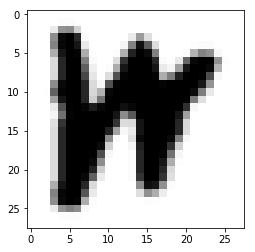

Форма властивостей (124800, 28, 28)


In [68]:
# Створення графіка
import matplotlib.pyplot as plt

plt.imshow(x_train[0],cmap=plt.cm.binary)
plt.show()

print("Форма властивостей {}".format(x_train.shape))

In [69]:
# Переформування масиву з 124800х1 до 124800
y_train = y_train.ravel()
y_test = y_test.ravel()

print("Форма відповідей {}".format(y_train.shape))

Форма відповідей (124800,)


In [70]:
# Імпортуемо бібліотекy з нейронную мережею
import tensorflow.keras as keras
import tensorflow as tf

# Для отримання більш точної моделі, треба змаштабувати дані. Метод нормалізації.
# Приймає зачення від 0 до 1
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

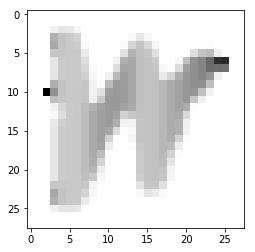

In [71]:
plt.imshow(x_train[0],cmap=plt.cm.binary)
plt.show()

In [73]:
x_valid, x_train = x_train[:5000], x_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [79]:
x_valid = x_valid.astype(np.float32).reshape(-1, 28*28)
x_train = x_train.astype(np.float32).reshape(-1, 28*28)
x_test = x_test.astype(np.float32).reshape(-1, 28*28)

print(x_valid.shape)
print(x_train.shape)
print(x_test.shape)

(5000, 784)
(119800, 784)
(20800, 784)


In [96]:
from functools import partial

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = 27

batch_norm_momentum = 0.9

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

he_init = tf.variance_scaling_initializer()

my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
bn3 = tf.nn.elu(my_batch_norm_layer(hidden3))
logits_before_bn = my_dense_layer(bn3, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

Y_proba = tf.nn.softmax(logits, name="Y_proba")

In [97]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [104]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

n_epochs = 1000
batch_size = 100

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(x_train))
        for rnd_indices in np.array_split(rnd_idx, len(x_train) // batch_size):
            X_batch, y_batch = x_train[rnd_indices], y_train[rnd_indices]
            sess.run([training_op, extra_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: x_valid, y: y_valid})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./mnist_letters.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./mnist_letters.ckpt")
    acc_test = accuracy.eval(feed_dict={X: x_test, y: y_test})
    predictions = Y_proba.eval(feed_dict={X: x_test, y: y_test})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.396871	Best loss: 0.396871	Accuracy: 86.98%
1	Validation loss: 0.330344	Best loss: 0.330344	Accuracy: 88.90%
2	Validation loss: 0.306921	Best loss: 0.306921	Accuracy: 89.16%
3	Validation loss: 0.282561	Best loss: 0.282561	Accuracy: 90.88%
4	Validation loss: 0.282101	Best loss: 0.282101	Accuracy: 90.24%
5	Validation loss: 0.264081	Best loss: 0.264081	Accuracy: 90.84%
6	Validation loss: 0.264189	Best loss: 0.264081	Accuracy: 91.28%
7	Validation loss: 0.250019	Best loss: 0.250019	Accuracy: 91.62%
8	Validation loss: 0.270551	Best loss: 0.250019	Accuracy: 91.70%
9	Validation loss: 0.263618	Best loss: 0.250019	Accuracy: 91.64%
10	Validation loss: 0.268514	Best loss: 0.250019	Accuracy: 91.86%
11	Validation loss: 0.254490	Best loss: 0.250019	Accuracy: 91.98%
12	Validation loss: 0.265174	Best loss: 0.250019	Accuracy: 91.76%
13	Validation loss: 0.265742	Best loss: 0.250019	Accuracy: 91.70%
14	Validation loss: 0.264081	Best loss: 0.250019	Accuracy: 92.02%
15	Validation loss: 

In [105]:
print(np.argmax(predictions[5]))

1


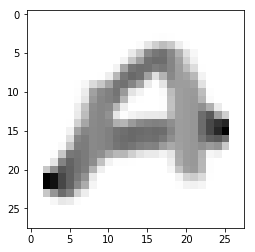

In [107]:
x_test = x_test.reshape(x_test.shape[0], 28, 28, order="A")

plt.imshow(x_test[5],cmap=plt.cm.binary)
plt.show()

In [108]:
# Декодування літер з масиву-прогнозування
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

In [109]:
preds = np.array(one_hot_decode(predictions))

In [110]:
print(preds.shape)
print(y_test.shape)

(20800,)
(20800,)


In [111]:
# Підрахунок правильних і неправльних результатів
correct = np.where(preds==y_test)[0]
incorrect = np.where(preds!=y_test)[0]

In [112]:
print(correct.shape)
print(incorrect.shape)

(19047,)
(1753,)


In [113]:
# К-сть картинок для зображення
n_view = incorrect.shape[0]

In [114]:
from numpy.random import permutation

# Отримання випадкового вибору з правильно-прогнозованих картинок
idx = permutation(correct)[:n_view]
idx_incorrect = permutation(incorrect)[:n_view]

In [115]:
# Створення масиву випадкових результатів
preds_correct = preds[idx]
preds_incorrect = preds[idx_incorrect]

imgs = x_test[idx]
imgs_incorrect = x_test[idx_incorrect]

imgs.shape

(1753, 28, 28)

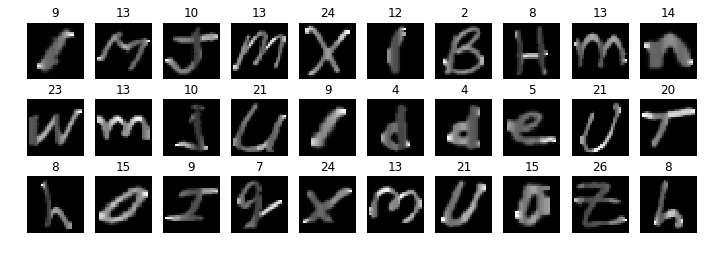

In [116]:
"""
A a = 1
B b = 2
C c = 3
D d = 4
E e = 5
F f = 6
G g = 7
H h = 8
I i = 9
J j = 10
K k = 11
L l = 12
M m = 13
N n = 14
O o = 15
P p = 16
Q q = 17
R r = 18
S s = 19
T t = 20
U u = 21
V v = 22
W w = 23
X x = 24
Y y = 25
Z z = 26 
"""
# Зображення перших 30 картинок рупоисних літер
f = plt.figure(figsize=(12,4))

for i in range(30):
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title(preds_correct[i])
    img = imgs[i].astype('float32')
    plt.imshow(img, cmap='gray')